# Model tuning from subset of features
@LaurentMombaerts @VladimirLevin

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import time
import seaborn as sns

# Parallel Computing
from joblib import Parallel, delayed

# ML
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler

# Maths
from scipy.interpolate import interp1d
# from arch import arch_model

# Paths tricks
import os
from pathlib import Path

df_features = pd.read_parquet('df_features_train.parquet') 
# df_features = pd.read_parquet('~/data/df_features_train.parquet') 

datapath = os.path.join(str(Path.home()), 'ownCloud', 'Data', 'Kaggle', 'optiver-realized-volatility-prediction')

# Load dataset
train_targets = pd.read_csv(os.path.join(datapath,'train.csv')) 
all_stocks_ids = train_targets['stock_id'].unique()
all_time_ids = train_targets['time_id'].unique()

train_targets['row_id'] = train_targets['stock_id'].astype(str) + '-' + train_targets['time_id'].astype(str)
train_targets = train_targets[['row_id','target']]

In [2]:
train_targets

,row_id,target
0,0-5,0.004136
1,0-11,0.001445
2,0-16,0.002168
3,0-31,0.002195
4,0-62,0.001747
...,...,...
428927,126-32751,0.003461
428928,126-32753,0.003113
428929,126-32758,0.004070
428930,126-32763,0.003357


In [3]:
# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    
    df['stock_id'] = [df['row_id'][i].split('-')[0] for i in range(df.shape[0])]
    df['time_id'] = [df['row_id'][i].split('-')[1] for i in range(df.shape[0])]
            
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 
                #'log_return2_realized_volatility', 
                #'log_return3_realized_volatility', 'log_return4_realized_volatility', 
                'log_returnMidprice_realized_volatility',
                #'log_return1_realized_volatility_480', 'log_return2_realized_volatility_480',
                #'log_return3_realized_volatility_480', 'log_return4_realized_volatility_480',
                #'log_returnMidprice_realized_volatility_480',
                #'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300',
                #'log_return3_realized_volatility_300', 'log_return4_realized_volatility_300',
                #'log_returnMidprice_realized_volatility_300', 
                #'log_return1_realized_volatility_120', 'log_return2_realized_volatility_120',
                #'log_return3_realized_volatility_120', 'log_return4_realized_volatility_120',
                #'log_returnMidprice_realized_volatility_120',         
                'trade_log_return_realized_volatility']
                #'trade_log_return_realized_volatility_480', 
                #'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_120']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the time id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    
    return df

# Competition metric
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [4]:
print(df_features.columns)

Index(['wap_sum', 'wap_mean', 'wap_std', 'mid_price_sum', 'mid_price_mean',
       'mid_price_std', 'log_return1_sum', 'log_return1_realized_volatility',
       'log_return1_mean', 'log_return1_std', 'log_returnMidprice_sum',
       'log_returnMidprice_realized_volatility', 'log_returnMidprice_mean',
       'log_returnMidprice_std', 'wap_imbalance1_sum', 'wap_imbalance1_mean',
       'wap_imbalance1_std', 'total_volume_sum', 'total_volume_mean',
       'total_volume_std', 'volume_imbalance_sum', 'volume_imbalance_mean',
       'volume_imbalance_std', 'spread_sum', 'depth_imbalance_sum', 'row_id',
       'trade_log_return_realized_volatility',
       'trade_seconds_in_bucket_count_unique', 'trade_size_sum',
       'trade_order_count_sum', 'trade_order_count_mean', 'trade_roll_measure',
       'trade_roll_impact', 'trade_amihud', 'trade_traded_volume',
       'trade_avg_trade_size'],
      dtype='object')


C:\Users\laurent\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


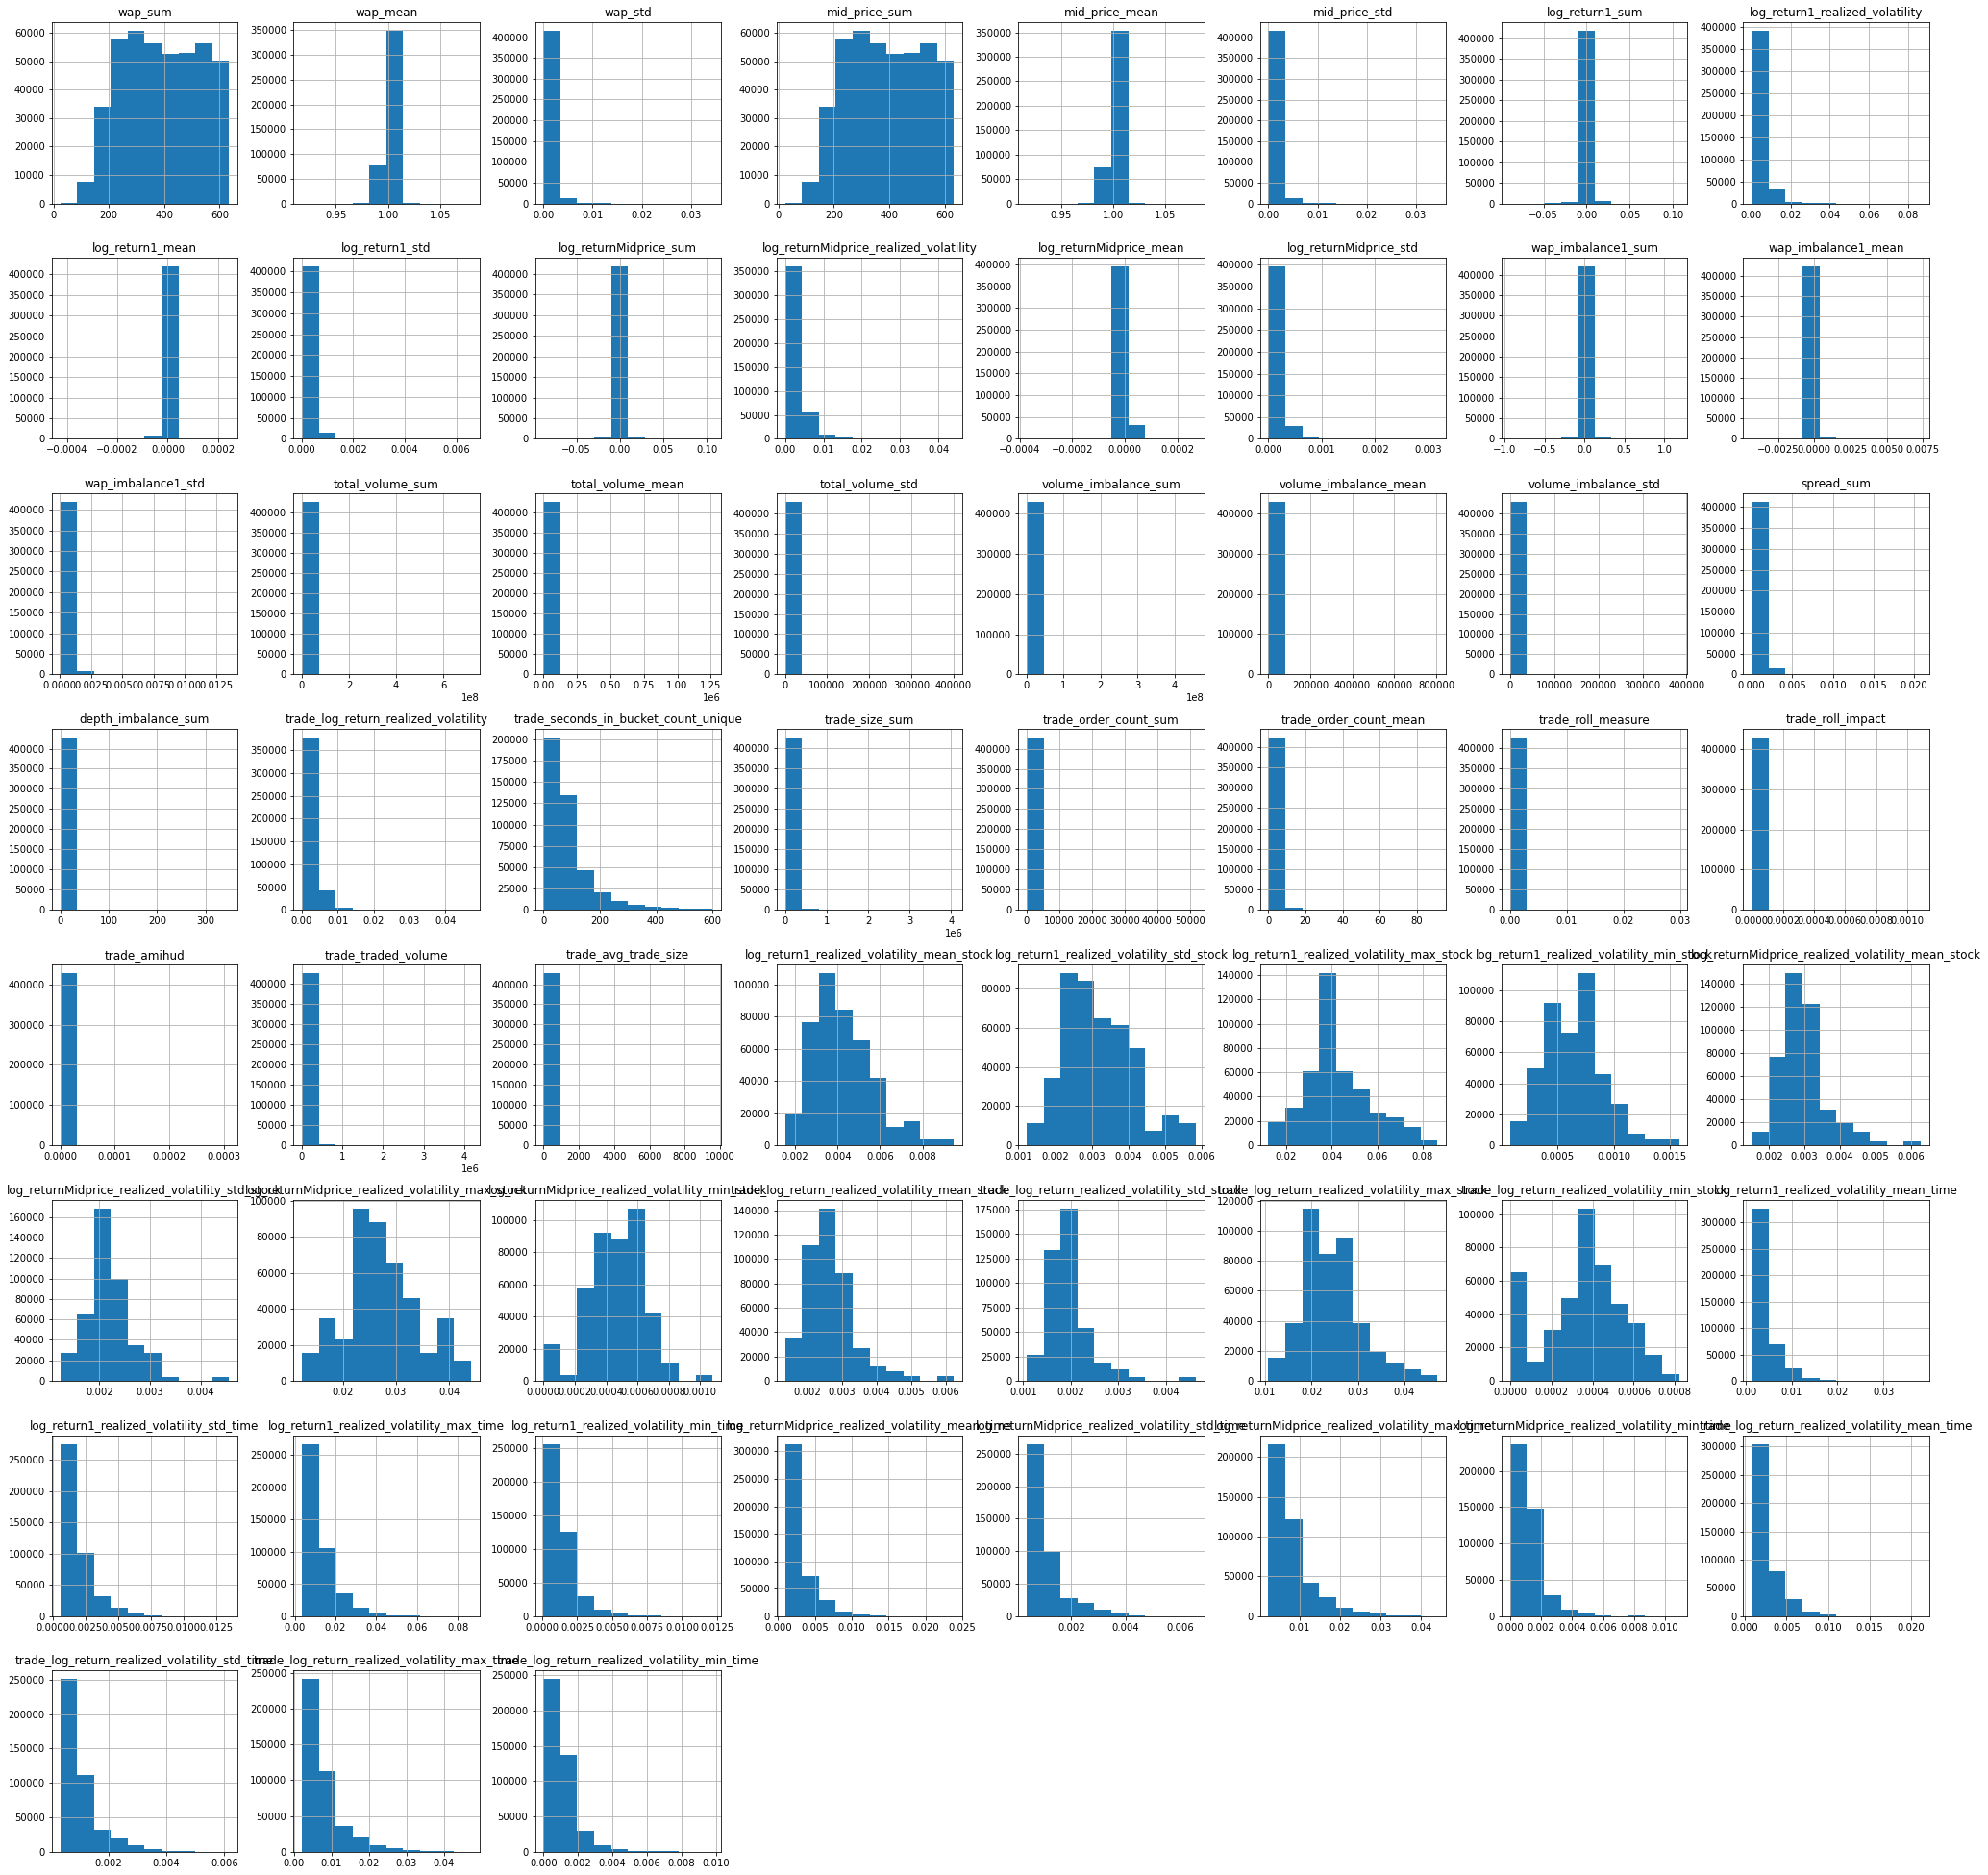

In [5]:
fig = plt.figure(figsize=(35,35))
ax = fig.gca()
get_time_stock(df_features).hist(ax = ax)
plt.show()

# Trials hyper param XGB

In [6]:
def feval_rmspe(y_pred, lgb_train):
    
    y_true = lgb_train.get_label()
    
    return 'RMSPE', rmspe(y_true, y_pred), False

# Dataset
X = df_features
y = train_targets['target']
groups = [X['row_id'][i].split('-')[1] for i in range(X.shape[0])]

# XGB
random_splits = [0]


param_grid = {'learning_rate': 0.03,
              'max_depth': 3,
              'subsample': 0.25,
              #'min_child_weight': 54,
              'colsample_bytree': 0.5,
              'alpha' : 0.001,
              'lambda' : 0.1
              }

list_rmspe = []

for i in random_splits:
    
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=i)
    gss.get_n_splits()
    
    for train, test in gss.split(X, y, groups):
        
        # CV definition
        x_train, x_val = X.iloc[train,:].reset_index(drop=True), X.iloc[test,:].reset_index(drop=True)
        y_train, y_val = y[train].reset_index(drop=True),y[test].reset_index(drop=True)

        # Add other stocks volatility at same time id and this stock overall volatility
        x_val = get_time_stock(x_val).drop(['row_id','time_id'],axis=1)
        x_train = get_time_stock(x_train).drop(['row_id','time_id'],axis=1)
        
        # Hot encoding, or removal
        x_train.drop(['stock_id'],axis=1,inplace=True)
        x_val.drop(['stock_id'],axis=1,inplace=True)
        #= x_train['stock_id'].astype(int)
        #x_val['stock_id'] = x_val['stock_id'].astype(int)
                
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        
        # Summary
        eval_set = [(x_train,y_train),(x_val, y_val)]
        
        # Model definition loop
        model = XGBRegressor(random_state=42, param=param_grid, n_estimators=1000)

        model.fit(x_train, y_train, early_stopping_rounds=100, eval_set=eval_set, sample_weight = train_weights, sample_weight_eval_set = [train_weights,val_weights], verbose=True)

        # Prediction
        yhat = model.predict(x_val)
        list_rmspe.append(rmspe(y_val,yhat))

print('Mean of RMSPE : ', np.mean(np.array(list_rmspe)), ' +- ', np.std(np.array(list_rmspe)))

# make predictions for test data
#y_pred = model.predict(X_val)

[21:47:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.448385	validation_1-rmse:0.448365
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:0.403545	validation_1-rmse:0.403528
[2]	validation_0-rmse:0.363191	validation_1-rmse:0.363173
[3]	validation_0-rmse:0.326873	validation_1-rmse:0.326855
[4]	validation_0-rmse:0.294183	validation_1-rmse:0.294167
[5]	validation_0-rmse:0.264765	validation_1-rmse:0.264748
[6]	validation_0-rmse:0.238289	validation_1-rmse:0.238272
[7]	validation_0-rmse:0.214461	validation_1-rmse:0.214444
[8]	validation_0-rmse:0.193014	validation_1-rmse:0.192998
[9]	validation_0-rmse:0.173714	validation_1-rmse:0.173697
[10]	validation_0-rmse:0.156342	validation_1-rmse:0.156326
[11]	validation_0-rmse:0.140707	validation_1-rmse:0.140692
[12]	validation_0-rmse:0.1

In [84]:
scaler = StandardScaler()
df_feats = df_features.drop(['row_id'],axis=1)
X = scaler.fit_transform(df_feats)
print(np.mean(X[:,1]))
print(np.std(X[:,1]))

6.200978408421529e-14
0.9999999999999999


# Trials hyperparam LGBM

In [87]:
def feval_rmspe(y_pred, lgb_train):
    
    y_true = lgb_train.get_label()
    
    return 'RMSPE', rmspe(y_true, y_pred), False

# Dataset
scaler = StandardScaler()
df_feats = df_features.drop(['row_id'],axis=1)
df_feats = pd.DataFrame(scaler.fit_transform(df_feats),columns=df_feats.columns)
X = pd.concat([df_feats,df_features['row_id']],axis=1)
#X = scaler.fit_transform(df_features)
y = train_targets['target']
groups = [X['row_id'][i].split('-')[1] for i in range(X.shape[0])]

# Hyperparammeters (just basic)
params = {
  'objective': 'rmse',  
  'boosting_type': 'gbdt',
  'num_leaves': 100,
  'n_jobs': -1,
  'learning_rate': 0.05,
  'feature_fraction': 0.8,
  'bagging_fraction': 0.8,
  'verbose': -1,
  'lambda_l1' : 10,
  'lambda_l2' : 10
}

list_rmspe = []
random_splits = [0,1,2,3]
for i in random_splits:
    
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=i)
    gss.get_n_splits()
    
    for train, test in gss.split(X, y, groups):
        
        # CV definition
        x_train, x_val = X.iloc[train,:].reset_index(drop=True), X.iloc[test,:].reset_index(drop=True)
        y_train, y_val = y[train].reset_index(drop=True),y[test].reset_index(drop=True)

        # Add other stocks volatility at same time id and this stock overall volatility
        x_val = get_time_stock(x_val).drop(['row_id','time_id'],axis=1)
        x_train = get_time_stock(x_train).drop(['row_id','time_id'],axis=1)
        
        #x_train['stock_id'] = x_train['stock_id'].astype(int)
        #x_val['stock_id'] = x_val['stock_id'].astype(int)
        
        x_train.drop(['stock_id'],axis=1,inplace=True)
        x_val.drop(['stock_id'],axis=1,inplace=True)
        
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        #train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        #val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights)
        
        # Model definition
        model = lgb.train(params = params, 
                      train_set = train_dataset, 
                      valid_sets = [train_dataset, val_dataset], 
                      num_boost_round = 10000, 
                      early_stopping_rounds = 50, 
                      verbose_eval = 50,
                      feval = feval_rmspe)

        # Prediction
        yhat = model.predict(x_val)
        list_rmspe.append(rmspe(y_val,yhat))

print('Mean of RMSPE : ', np.mean(np.array(list_rmspe)), ' +- ', np.std(np.array(list_rmspe)))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000492059	training's RMSPE: 0.228117	valid_1's rmse: 0.000505395	valid_1's RMSPE: 0.232311
[100]	training's rmse: 0.000453915	training's RMSPE: 0.210433	valid_1's rmse: 0.000492909	valid_1's RMSPE: 0.226572
[150]	training's rmse: 0.000433821	training's RMSPE: 0.201118	valid_1's rmse: 0.000495444	valid_1's RMSPE: 0.227737
Early stopping, best iteration is:
[114]	training's rmse: 0.0004483	training's RMSPE: 0.207831	valid_1's rmse: 0.000492377	valid_1's RMSPE: 0.226328
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000489821	training's RMSPE: 0.227975	valid_1's rmse: 0.000530432	valid_1's RMSPE: 0.239865
[100]	training's rmse: 0.000451883	training's RMSPE: 0.210318	valid_1's rmse: 0.000519804	valid_1's RMSPE: 0.235059
Early stopping, best iteration is:
[92]	training's rmse: 0.000456035	training's RMSPE: 0.212251	valid_1's rmse: 0.000519189	valid_1's RMSPE: 0.234781
T

# LGBM Hyperparameter tuning grid

In [52]:
def feval_rmspe(y_pred, lgb_train):
    
    y_true = lgb_train.get_label()
    
    return 'RMSPE', rmspe(y_true, y_pred), False

# Dataset
X = df_features
y = train_targets['target']
groups = [X['row_id'][i].split('-')[1] for i in range(X.shape[0])]

# Hyperparammeters (just basic)
params = {
  'num_boost_round' : [250,300,350,400],
  'num_leaves': [70,80,90,100]
}

params_grid = list(ParameterGrid(params))

list_split = []
random_splits = [0,1,2,3,4]
for i in random_splits:
    
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=i)
    gss.get_n_splits()
    
    list_rmspe = []
    for train, test in gss.split(X, y, groups):
        
        # CV definition
        x_train, x_val = X.iloc[train,:].reset_index(drop=True), X.iloc[test,:].reset_index(drop=True)
        y_train, y_val = y[train].reset_index(drop=True),y[test].reset_index(drop=True)

        # Add other stocks volatility at same time id and this stock overall volatility
        x_val = get_time_stock(x_val).drop(['row_id','time_id'],axis=1)
        x_train = get_time_stock(x_train).drop(['row_id','time_id'],axis=1)
        
        #x_train['stock_id'] = x_train['stock_id'].astype(int)
        #x_val['stock_id'] = x_val['stock_id'].astype(int)
        
        x_train.drop(['stock_id'],axis=1,inplace=True)
        x_val.drop(['stock_id'],axis=1,inplace=True)
        
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        #train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        #val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights)
        
        # Model definition
        start = time.time()
        for i in range(np.array(params_grid).shape[0]):
            print('Training hyperset number', i, '...')
            
            params_grid[i]['num_threads'] = -1
            params_grid[i]['learning_rate'] = 0.02
            params_grid[i]['objective'] = 'rmse'
            params_grid[i]['boosting_type'] = 'gbdt'
            params_grid[i]['feature_fraction'] = 0.8
            params_grid[i]['bagging_fraction'] = 0.8
            params_grid[i]['lambda_l1'] = 10
            params_grid[i]['lambda_l2'] = 5
            
            print(params_grid[i])
            model = lgb.train(params = params_grid[i], 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 0,
                          feval = feval_rmspe)

            # Prediction
            yhat = model.predict(x_val)
            list_rmspe.append(rmspe(y_val,yhat))
            
        print('['+time.strftime('%X')+']', 'Hyperparam training on single group split took ',  time.time() - start, 'seconds') 
        
    list_split.append(list_rmspe)
        
print('Mean of RMSPE : ', np.mean(np.array(list_rmspe)), ' +- ', np.std(np.array(list_rmspe)))


Training hyperset number 0 ...
{'num_boost_round': 250, 'num_leaves': 70, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}


C:\Users\laurent\anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13320
[LightGBM] [Info] Number of data points in the train set: 343150, number of used features: 59
[LightGBM] [Info] Start training from score 0.001796
Training hyperset number 1 ...
{'num_boost_round': 250, 'num_leaves': 80, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13320
[LightGBM] [Info] Number of data points in the train set: 343150, number of used features: 59
[LightGBM] [Info] Start training from score 0.001796


C:\Users\laurent\anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training hyperset number 2 ...
{'num_boost_round': 250, 'num_leaves': 90, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13320
[LightGBM] [Info] Number of data points in the train set: 343150, number of used features: 59
[LightGBM] [Info] Start training from score 0.001796
Training hyperset number 3 ...
{'num_boost_round': 250, 'num_leaves': 100, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058683 seconds.
You can set `force_col_wise=true` to remove the overhea

C:\Users\laurent\anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13322
[LightGBM] [Info] Number of data points in the train set: 343150, number of used features: 59
[LightGBM] [Info] Start training from score 0.001793
Training hyperset number 1 ...
{'num_boost_round': 250, 'num_leaves': 80, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13322
[LightGBM] [Info] Number of data points in the train set: 343150, number of used features: 59
[LightGBM] [Info] Start training from score 0.001793


C:\Users\laurent\anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training hyperset number 2 ...
{'num_boost_round': 250, 'num_leaves': 90, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13322
[LightGBM] [Info] Number of data points in the train set: 343150, number of used features: 59
[LightGBM] [Info] Start training from score 0.001793
Training hyperset number 3 ...
{'num_boost_round': 250, 'num_leaves': 100, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056567 seconds.
You can set `force_col_wise=true` to remove the overhea

C:\Users\laurent\anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13323
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 59
[LightGBM] [Info] Start training from score 0.001805
Training hyperset number 1 ...
{'num_boost_round': 250, 'num_leaves': 80, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13323
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 59
[LightGBM] [Info] Start training from score 0.001805


C:\Users\laurent\anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training hyperset number 2 ...
{'num_boost_round': 250, 'num_leaves': 90, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13323
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 59
[LightGBM] [Info] Start training from score 0.001805
Training hyperset number 3 ...
{'num_boost_round': 250, 'num_leaves': 100, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081613 seconds.
You can set `force_col_wise=true` to remove the overhea

C:\Users\laurent\anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13320
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 59
[LightGBM] [Info] Start training from score 0.001799
Training hyperset number 1 ...
{'num_boost_round': 250, 'num_leaves': 80, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13320
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 59
[LightGBM] [Info] Start training from score 0.001799


C:\Users\laurent\anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training hyperset number 2 ...
{'num_boost_round': 250, 'num_leaves': 90, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13320
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 59
[LightGBM] [Info] Start training from score 0.001799
Training hyperset number 3 ...
{'num_boost_round': 250, 'num_leaves': 100, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061231 seconds.
You can set `force_col_wise=true` to remove the overhea

C:\Users\laurent\anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13323
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 59
[LightGBM] [Info] Start training from score 0.001803
Training hyperset number 1 ...
{'num_boost_round': 250, 'num_leaves': 80, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13323
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 59
[LightGBM] [Info] Start training from score 0.001803


C:\Users\laurent\anaconda3\envs\tf-gpu\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training hyperset number 2 ...
{'num_boost_round': 250, 'num_leaves': 90, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13323
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 59
[LightGBM] [Info] Start training from score 0.001803
Training hyperset number 3 ...
{'num_boost_round': 250, 'num_leaves': 100, 'num_threads': -1, 'learning_rate': 0.02, 'objective': 'rmse', 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 10, 'lambda_l2': 5}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054750 seconds.
You can set `force_col_wise=true` to remove the overhea

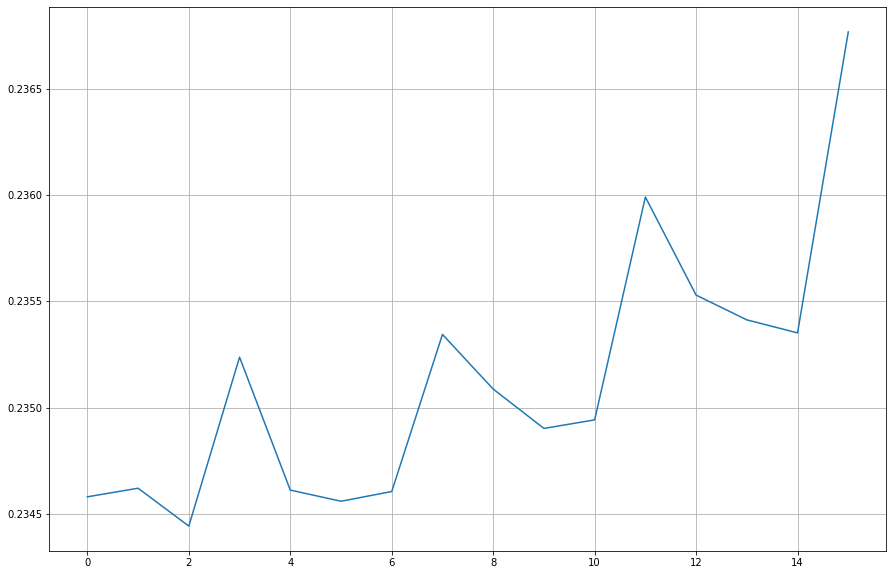

,num_boost_round,num_leaves,num_threads,learning_rate,objective,boosting_type,feature_fraction,bagging_fraction,lambda_l1,lambda_l2,rmspe
0,250,70,-1,0.02,rmse,gbdt,0.8,0.8,10,5,0.234580
1,250,80,-1,0.02,rmse,gbdt,0.8,0.8,10,5,0.234620
2,250,90,-1,0.02,rmse,gbdt,0.8,0.8,10,5,0.234442
3,250,100,-1,0.02,rmse,gbdt,0.8,0.8,10,5,0.235237
4,300,70,-1,0.02,rmse,gbdt,0.8,0.8,10,5,0.234612
5,300,80,-1,0.02,rmse,gbdt,0.8,0.8,10,5,0.234559
6,300,90,-1,0.02,rmse,gbdt,0.8,0.8,10,5,0.234605
7,300,100,-1,0.02,rmse,gbdt,0.8,0.8,10,5,0.235344
8,350,70,-1,0.02,rmse,gbdt,0.8,0.8,10,5,0.235087
9,350,80,-1,0.02,rmse,gbdt,0.8,0.8,10,5,0.234902


In [59]:
results = pd.DataFrame(list_split[4],columns=['rmspe'])
concat_results_grid = pd.concat([pd.DataFrame(params_grid),results],axis=1)
np.min(list_split[0])

plt.figure(figsize=(15,10))
plt.plot(results)
#plt.plot(results[concat_results_grid['num_leaves'] == 100])
#plt.plot(results[concat_results_grid['num_boost_round'] == 600])
plt.grid()
plt.show()

concat_results_grid
#concat_results_grid.iloc[115]

In [42]:
list_split

[[0.22614292596633231,
  0.22599004816653712,
  0.22599988107813085,
  0.22555998990884776,
  0.2260866194683871,
  0.2259242714832768,
  0.22612015952680706,
  0.22564325907845678],
 [0.23406105510971983,
  0.2344356069011771,
  0.2344408692062732,
  0.23446334338700542,
  0.23412916473443796,
  0.23457014730552164,
  0.23500968912290646,
  0.23479481223845738],
 [0.23018969823800495,
  0.230324060968803,
  0.2300834536889073,
  0.2298851018407149,
  0.23101547534582637,
  0.23105924474237885,
  0.23174961258797988,
  0.23099810466983486],
 [0.23091861423574261,
  0.23085337843992693,
  0.23070192524429844,
  0.23063226421124472,
  0.2307750150583967,
  0.23085157467780437,
  0.23062749412828895,
  0.23072927241304358],
 [0.23465676861176765,
  0.23466851173045142,
  0.2346741824191902,
  0.23455010530017786,
  0.2345975485113276,
  0.23490733888467433,
  0.23480437137855842,
  0.23461654679542657]]

In [154]:
pd.concat([pd.DataFrame(params_grid),pd.DataFrame(list_rmspe,columns=['rmspe'])],axis=1).to_csv('result_table.csv')

In [7]:
params = {
  'num_boost_round' : [500,600],
  'num_leaves': [70,80,90,100],
  'feature_fraction': [0.8,0.9],
  'bagging_fraction': [0.8,0.9],
  'lambda_l1' : [0,0.1,0.2],
  'lambda_l2' : [0,0.1,0.2]
}

params_grid = list(ParameterGrid(params))
pd.DataFrame(params_grid)

,bagging_fraction,feature_fraction,lambda_l1,lambda_l2,num_boost_round,num_leaves
0,0.8,0.8,0.0,0.0,500,70
1,0.8,0.8,0.0,0.0,500,80
2,0.8,0.8,0.0,0.0,500,90
3,0.8,0.8,0.0,0.0,500,100
4,0.8,0.8,0.0,0.0,600,70
...,...,...,...,...,...,...
283,0.9,0.9,0.2,0.2,500,100
284,0.9,0.9,0.2,0.2,600,70
285,0.9,0.9,0.2,0.2,600,80
286,0.9,0.9,0.2,0.2,600,90


In [ ]:
0.22583780294522968  +-  0.0